<a href="https://colab.research.google.com/github/Oviing/market_basket_analysis/blob/main/market_basked_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements

In [ ]:
!pip install kaggle

In [ ]:
!pip install pyspark

     |████████████████████████████████| 212.4MB 72kB/s 
     |████████████████████████████████| 204kB 18.4MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=648c10315b2dc7434af5039b22d64f09ae73a3069995d49e846b68c2aa027126
  Stored in directory: /root/.cache/pip/wheels/40/1b/2c/30f43be2627857ab80062bef1527c0128f7b4070b6b2d02139
Successfully built pyspark


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [ ]:
!kaggle datasets download -d ashirwadsangwan/imdb-dataset

100% 1.43G/1.44G [00:16<00:00, 84.7MB/s]
100% 1.44G/1.44G [00:17<00:00, 90.7MB/s]


In [ ]:
!unzip imdb-dataset.zip

Archive:  imdb-dataset.zip
  inflating: name.basics.tsv.gz      
  inflating: name.basics.tsv/name.basics.tsv  
  inflating: title.akas.tsv.gz       
  inflating: title.akas.tsv/title.akas.tsv  
  inflating: title.basics.tsv.gz     
  inflating: title.basics.tsv/title.basics.tsv  
  inflating: title.principals.tsv.gz  
  inflating: title.principals.tsv/title.principals.tsv  
  inflating: title.ratings.tsv.gz    
  inflating: title.ratings.tsv/title.ratings.tsv  


In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
conf = SparkConf().setAppName("MarketBasketAnalysis")
conf = (conf.setMaster('local[*]')
        .set('spark.executor.memory', '8G')
        .set('spark.driver.memory', '45G')
        .set('spark.driver.maxResultSize', '0'))
sc = SparkContext(conf=conf)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from pyspark.sql import SQLContext
spark = SQLContext(sc)

# Explore Data Analysis

Our goal is to perform a market basked analysis. We want to find fequent items. For us frequent items are actors / actress, which played together or not in different movies (baskets). We want to find a assiation rule that find with a certain frequency persons who played in movies together.

In our analysis we are using three files:
* title.basics (Movies)
* name.baiscs (Persons)
* title.principals (Who played in which movie)

In [ ]:
principals = spark.read.csv('/content/title.principals.tsv', sep='\t' , header=True, inferSchema=True)

In [ ]:
principals.show(5)

+---------+--------+---------+---------------+--------------------+-----------+
|   tconst|ordering|   nconst|       category|                 job| characters|
+---------+--------+---------+---------------+--------------------+-----------+
|tt0000001|       1|nm1588970|           self|                  \N|["Herself"]|
|tt0000001|       2|nm0005690|       director|                  \N|         \N|
|tt0000001|       3|nm0374658|cinematographer|director of photo...|         \N|
|tt0000002|       1|nm0721526|       director|                  \N|         \N|
|tt0000002|       2|nm1335271|       composer|                  \N|         \N|
+---------+--------+---------+---------------+--------------------+-----------+
only showing top 5 rows



The file principales is a collection of a movie title (unique id) and a person id. We are interested to find movies and person ids where the category is actor / actress

In [ ]:
movie = spark.read.csv('/content/title.basics.tsv.gz', sep='\t' , header=True, inferSchema=True)

In [ ]:
movie.show(5)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation,Short|
|tt0000003|    short|      Pauvre Pierrot|      Pauvre Pierrot|      0|     1892|     \N|             4|Animation,Comedy,...|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|            \N|     Animation,Short|
|tt0000005|    short|    Blacksmith Scene|    Blacksmith Scene|      0|     1893|     \N|             1|        Comedy

In [ ]:
person = spark.read.csv('/content/name.basics.tsv.gz', sep='\t' , header=True, inferSchema=True)

In [ ]:
person.show(5)

+---------+---------------+---------+---------+--------------------+--------------------+
|   nconst|    primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|
+---------+---------------+---------+---------+--------------------+--------------------+
|nm0000001|   Fred Astaire|     1899|     1987|soundtrack,actor,...|tt0050419,tt00531...|
|nm0000002|  Lauren Bacall|     1924|     2014|  actress,soundtrack|tt0117057,tt00373...|
|nm0000003|Brigitte Bardot|     1934|       \N|actress,soundtrac...|tt0049189,tt00599...|
|nm0000004|   John Belushi|     1949|     1982|actor,writer,soun...|tt0078723,tt00804...|
|nm0000005| Ingmar Bergman|     1918|     2007|writer,director,a...|tt0050986,tt00839...|
+---------+---------------+---------+---------+--------------------+--------------------+
only showing top 5 rows



If we using the person id we can use it to find name, year and other information about a person with this id

In [ ]:
person.filter(person.nconst =='nm1588970').show()

+---------+-----------+---------+---------+-----------------+-------------------+
|   nconst|primaryName|birthYear|deathYear|primaryProfession|     knownForTitles|
+---------+-----------+---------+---------+-----------------+-------------------+
|nm1588970| Carmencita|     1868|     1910|       soundtrack|tt0057728,tt0000001|
+---------+-----------+---------+---------+-----------------+-------------------+



In [ ]:
#create a temp view
person.createOrReplaceTempView("actor")
principals.createOrReplaceTempView("principals")
movie.createOrReplaceTempView("movie")

The table principals shows the relation between a movie and the associated crew. We perform first a join on the relation of movie id and movie id on the principal table and select the titels. Then we perform a second join on this result in the actor / actress id and the principal table and selection name of the actor and actor id

Now we have to filter as well the result, becasause currently we include all the members of the crew, but we are just interested in actors and actresses.
We just focus on movies.


In [ ]:
query = """SELECT movie.tconst, primaryTitle, p.nconst, primaryName, category
            FROM movie
            INNER JOIN principals as p
            ON p.tconst = movie.tconst
            INNER JOIN actor as a
            ON a.nconst = p.nconst
            WHERE (category = 'actor' or category = 'actress') and (movie.titleType = 'movie');
            """

In [ ]:
res = spark.sql(query)

In [ ]:
res.show(5)

+---------+-----------------+---------+--------------+--------+
|   tconst|     primaryTitle|   nconst|   primaryName|category|
+---------+-----------------+---------+--------------+--------+
|tt0083109| The Cabbage Soup|nm0000086|Louis de Funès|   actor|
|tt0062120|The Little Bather|nm0000086|Louis de Funès|   actor|
|tt0057422|    Squeak-squeak|nm0000086|Louis de Funès|   actor|
|tt0058089|         Fantomas|nm0000086|Louis de Funès|   actor|
|tt0067274|               Jo|nm0000086|Louis de Funès|   actor|
+---------+-----------------+---------+--------------+--------+
only showing top 5 rows



The query allows use to retrieve a table where we have in each row a movie id, an actor and the actor id, the title of a movie and to controll the category that it is an actor. In the result above we see that the actor with the id nm000086 played in several movies. Probably we find other actors which played a lot in other movies and sometimes some actors played often together. Later we will use the movie ids as buckets and find actors which played frequently together

In [ ]:
res.count()

1692821

In [ ]:
res.createOrReplaceTempView("query_result")

We can also find the top 10 actors which played in the most movies

In [ ]:
query = """SELECT nconst, COUNT(*) AS freq
           FROM query_result
           GROUP BY nconst
           ORDER BY freq desc
           LIMIT 10"""
query_res = spark.sql(query)

In [ ]:
query_res.createOrReplaceTempView("qr2")

In [ ]:
query2 = """SELECT DISTINCT primaryName, freq
        FROM query_result, qr2
        WHERE query_result.nconst = qr2.nconst
        ORDER BY freq desc"""

In [ ]:
query_res2 = spark.sql(query2)

In [ ]:
query_res.show()

+---------+----+
|   nconst|freq|
+---------+----+
|nm0103977| 798|
|nm0006982| 585|
|nm0648803| 565|
|nm0305182| 506|
|nm0623427| 438|
|nm0793813| 411|
|nm0246703| 391|
|nm0619107| 387|
|nm0007123| 380|
|nm7390393| 355|
+---------+----+



In [ ]:
query_res2.show()

+----------------+----+
|     primaryName|freq|
+----------------+----+
|    Brahmanandam| 798|
|     Adoor Bhasi| 585|
|Matsunosuke Onoe| 565|
|    Eddie Garcia| 506|
|      Prem Nazir| 438|
|    Sung-il Shin| 411|
|    Paquito Diaz| 391|
|Masayoshi Nogami| 387|
|       Mammootty| 380|
|  Aachi Manorama| 355|
+----------------+----+



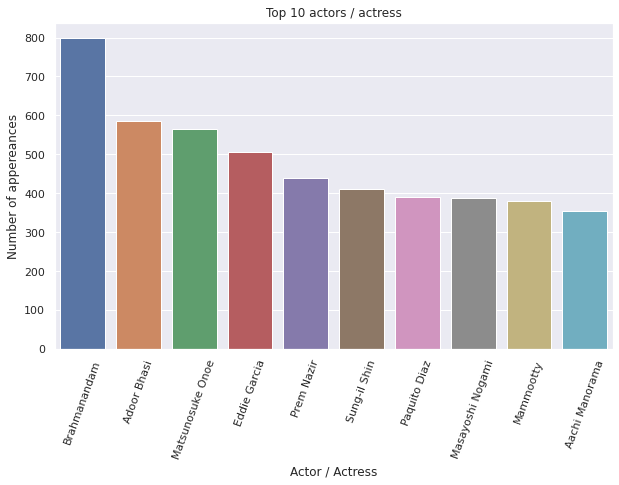

In [ ]:
sns.set(rc={'figure.figsize':(10,6)})
ax = sns.barplot(x = "primaryName", y = "freq", data = query_res2.toPandas())
ax.set(title = "Top 10 actors / actress", xlabel = "Actor / Actress", ylabel = "Number of appereances")
ax.set_xticklabels(ax.get_xticklabels(), rotation=70);

We see that some actors played in a lot of movies. The top is done by nm0103977 with 798 roles. nm0103977 is the id for Brahmanandam. Based on wikipedia he also holds the guiness book world record for the most appereances on a screen
https://en.wikipedia.org/wiki/Brahmanandam

Based on the diagram above we are not surprised if some persons appearing more often together.

In [ ]:
res.filter(res.nconst =='nm0103977').show()

+---------+--------------------+---------+------------+--------+
|   tconst|        primaryTitle|   nconst| primaryName|category|
+---------+--------------------+---------+------------+--------+
|tt1579862|          Prayathnam|nm0103977|Brahmanandam|   actor|
|tt1945122|    Kalyan Ram Kathi|nm0103977|Brahmanandam|   actor|
|tt0266727|     Little Soldiers|nm0103977|Brahmanandam|   actor|
|tt1575636|     Moodu Mukkalata|nm0103977|Brahmanandam|   actor|
|tt1575648|        O Chinadaana|nm0103977|Brahmanandam|   actor|
|tt5991618|Nuvekkadunte Nena...|nm0103977|Brahmanandam|   actor|
|tt0381484|    Pellamto Panemti|nm0103977|Brahmanandam|   actor|
|tt1579642|       Namasthe Anna|nm0103977|Brahmanandam|   actor|
|tt1579863|           Premikulu|nm0103977|Brahmanandam|   actor|
|tt1579590|      Kankana Baghya|nm0103977|Brahmanandam|   actor|
|tt1582477|         Bhavani IPS|nm0103977|Brahmanandam|   actor|
|tt3401910|            Okkadine|nm0103977|Brahmanandam|   actor|
|tt1575657|         Prema

Also if we check the second most appeared actor we find a similar result

In [ ]:
person.filter(person.nconst =='nm0006982').show()

+---------+-----------+---------+---------+--------------------+--------------------+
|   nconst|primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|
+---------+-----------+---------+---------+--------------------+--------------------+
|nm0006982|Adoor Bhasi|     1929|     1990|actor,director,mu...|tt0156920,tt02689...|
+---------+-----------+---------+---------+--------------------+--------------------+



We want now to display with wordcloud the most appeared actors name. We use the result of the previous query and just add the name on it to have a meaningful understanding of the result

In [ ]:
# Query the top 200 actors
query3 = """SELECT nconst, COUNT(*) AS orders_count
           FROM query_result
           GROUP BY nconst
           ORDER BY orders_count desc
           LIMIT 200"""
query_res3 = spark.sql(query3)
query_res3.createOrReplaceTempView("top_actors")

In [ ]:
query4 = """SELECT DISTINCT query_result.nconst, primaryName, orders_count
            FROM query_result, top_actors
            WHERE query_result.nconst = top_actors.nconst
            ORDER BY orders_count desc"""

query_res4 = spark.sql(query4)

In [ ]:
query_res4.show(5)

+---------+----------------+------------+
|   nconst|     primaryName|orders_count|
+---------+----------------+------------+
|nm0103977|    Brahmanandam|         798|
|nm0006982|     Adoor Bhasi|         585|
|nm0648803|Matsunosuke Onoe|         565|
|nm0305182|    Eddie Garcia|         506|
|nm0623427|      Prem Nazir|         438|
+---------+----------------+------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import countDistinct
query_res4.agg(countDistinct(query_res4.primaryName).alias('unique_counts')).collect()

[Row(unique_counts=200)]

With the query above we queried 200 actors, based on the ID. Now we want to create out of this a wordcloud. For a meaningful understanding we are using the actors name. To be sure, that an actor name does not appear more than ones, we counting the distinct values. The result should be 200

In [ ]:
wordcloud_rdd = query_res4.select('primaryName', 'orders_count').rdd.map(lambda row: row.asDict()).collect()

In [ ]:
q = wordcloud_rdd[0].values()
w = list(q)
w[0], w[1]

('Brahmanandam', 798)

In [ ]:
from collections import defaultdict

frequency_dict = defaultdict()

for i in range(0, len(wordcloud_rdd)):

  v = wordcloud_rdd[i].values()
  v = list(v)
  frequency_dict[v[0]] = v[1]

We built a dictionary for every row in the rdd and transformed it into a list of dictionary. For the wordcloud we now transformed again this list into one unique dictionary

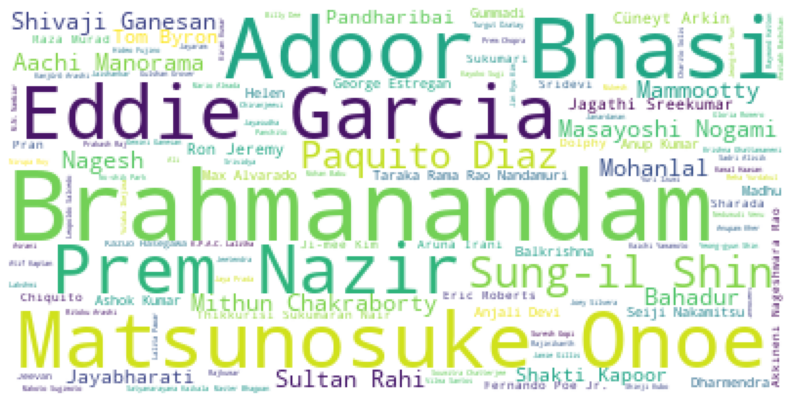

In [ ]:
wordcloud = WordCloud(background_color = "white").fit_words(frequency_dict)

# displaying the generated image
plt.figure(figsize = (14, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

We create now baskets with sets of items inside. Baskets are the movie id number and items are the person id 

# Creating Baskets

In [ ]:
from pyspark.sql.functions import collect_set

In [ ]:
query = """SELECT movie.tconst, primaryTitle, p.nconst, primaryName, category
            FROM movie
            INNER JOIN principals as p
            ON p.tconst = movie.tconst
            INNER JOIN actor as a
            ON a.nconst = p.nconst
            WHERE (category = 'actor' or category = 'actress') and (movie.titleType = 'movie');
            """

In [ ]:
rawData = spark.sql(query)
baskets = rawData.groupBy('tconst').agg(collect_set('nconst').alias('items'))

In [ ]:
baskets.show(5)

+---------+--------------------+
|   tconst|               items|
+---------+--------------------+
|tt0002591|[nm0029806, nm050...|
|tt0003689|[nm0910564, nm052...|
|tt0004272|[nm0092665, nm036...|
|tt0004336|[nm0268437, nm081...|
|tt0005209|[nm0593671, nm039...|
+---------+--------------------+
only showing top 5 rows



we create a list of baskests and we create a list of unique items

In [ ]:
baskets_rdd = baskets.select('items').rdd.flatMap(list)

In [ ]:
baskets_rdd.take(2)

[['nm0029806', 'nm0509573'],
 ['nm0910564',
  'nm0527801',
  'nm0399988',
  'nm0101071',
  'nm0694718',
  'nm0728289',
  'nm0585503']]

In [ ]:
basket_list = sc.parallelize(baskets_rdd.collect(), 3)

# SON Algorithm

For each row we now count how often a actro / actress appears.

In [ ]:
print(basket_list.getNumPartitions())

3


In [ ]:
minSupport = 140
numPartitions = basket_list.getNumPartitions()
adjSupport = minSupport/numPartitions
adjSupport

46.666666666666664

In [ ]:
import itertools
from operator import add

In [ ]:
# function to count frequent pairs
def count_pair_freq(x, pair):
  set_x = set(x)
  l = []
  for item in pair:
    set_item = set(item)
    if set_item.issubset(set_x):
      l.append((item, 1))
  return l

In [ ]:
# return lists that are greater than 0
def check_len(x):
  if len(x) > 0:
    return x

In [ ]:
def sum_of_items(x,y):
    return x+y

In [ ]:
# map and reduce the frequent items in the first step of the SON algorithm

def first_step(data, epsilon):
  flated_list = data.flatMap(list)
  
  # first map function
  singleton = flated_list.map(lambda item: (item, 1))

  #first reduce function
  sum_of_singleton = singleton.reduceByKey(sum_of_items)

  # filter out not frequent items
  candidates = sum_of_singleton.filter(lambda item: item[1] >= epsilon)

  # build a list with all frequent items
  frequent_singletons = candidates.map(lambda item: (item[0]))

  return frequent_singletons, candidates


In [ ]:
# second step of the son algorith to find frequent pairs on each worker
def second_step(data, epsilon, candidates):

  # create a candidate list and build a candidate pairs list
  candidate_list = candidates.collect()
  c = list(itertools.combinations(candidate_list, 2))

  # find frequent pairs on each worker and filter out all empty results
  mapper = data.flatMap(lambda x: count_pair_freq(x, c)).filter(lambda x: check_len(x)).cache()
  
  # sum the result per worker up per key
  reducer = mapper.reduceByKey(add)
  
  return reducer



In [ ]:
def SON(data, number_of_partitions, min_support):
  
  #creates a empty rdd to store the final results
  c_union = sc.parallelize([])

  first_step_union = sc.parallelize([])
  confidence_score = sc.parallelize([])

  #create the min_support for each partition (epsilon)
  partition_support  = min_support/number_of_partitions

  # iterate with a loop over each partition
  # since we start at 0 we have to consider the number of partitions - 1
  for k in range(1, 3):

    print("Step", k)
    
    for i in range(0, number_of_partitions):
    
      print("Chunk", i)
      partition = sc.parallelize(data.glom().collect()[i])
      if k < 2:

        # select frequent singletons per chunk
        frequent_items_per_chunk, r = first_step(partition, partition_support)

        #union of the candidates
        first_step_union = first_step_union.union(frequent_items_per_chunk).distinct()
        confidence_score = confidence_score.union(r)

      else:

        #building the candidate pairs 
        frequent_pairs = second_step(partition, partition_support, first_step_union)

        # union for each worker
        c_union = c_union.union(frequent_pairs)

  # sum up all the unions and filter out results hwich are smaller than the min_support
  w = c_union.reduceByKey(add)
  f = w.filter(lambda item: item[1] >= min_support).cache()
  q = confidence_score.reduceByKey(add)
  return f, q

In [ ]:
frequent_item_set, ci = SON(basket_list, 3, 140)

Step 1
Chunk 0
Chunk 1
Chunk 2
Step 2
Chunk 0
Chunk 1
Chunk 2


In [57]:
df = frequent_item_set.collect()

In [58]:
list_c = ci.collect()

checking the actor and how often this set is found

In [59]:
for i in list_c:
  a = i[0]
  for j in range(0, len(df)):
    fp = df[j][0]
    if (a == df[j][0][0]) or (a == df[j][0][1]):
      print("Actor in data file", i)
      print("Set of actor", df[j])

Actor in data file ('nm0419653', 303)
Set of actor (('nm0419653', 'nm0006982'), 162)
Actor in data file ('nm0046850', 348)
Set of actor (('nm0046850', 'nm0006982'), 169)
Actor in data file ('nm2082516', 161)
Set of actor (('nm2082516', 'nm0648803'), 147)
Actor in data file ('nm0623427', 438)
Set of actor (('nm0623427', 'nm0006982'), 237)
Actor in data file ('nm0006982', 585)
Set of actor (('nm0419653', 'nm0006982'), 162)
Actor in data file ('nm0006982', 585)
Set of actor (('nm0046850', 'nm0006982'), 169)
Actor in data file ('nm0006982', 585)
Set of actor (('nm0623427', 'nm0006982'), 237)
Actor in data file ('nm0648803', 565)
Set of actor (('nm2082516', 'nm0648803'), 147)


return of the SON algorithm

In [60]:
df

[(('nm0419653', 'nm0006982'), 162),
 (('nm0046850', 'nm0006982'), 169),
 (('nm2082516', 'nm0648803'), 147),
 (('nm0623427', 'nm0006982'), 237)]

computing the confidence

In [61]:
def confidence(freq, support):

  for i in range(0, len(freq)):

    a = freq[i][0][0]
    b = freq[i][0][1]

    f = freq[i][1]

    for j in range(0, len(support)):

      if a == support[j][0]:
        print("Confidence for", a, "->", b, "is", f / support[j][1])

      elif b == support[j][0]:
        print("Confidence for", b, "->", a, "is", f / support[j][1])
        print('')
      else:
        pass
        


In [62]:
confidence(df, list_c)

Confidence for nm0419653 -> nm0006982 is 0.5346534653465347
Confidence for nm0006982 -> nm0419653 is 0.27692307692307694

Confidence for nm0046850 -> nm0006982 is 0.48563218390804597
Confidence for nm0006982 -> nm0046850 is 0.28888888888888886

Confidence for nm2082516 -> nm0648803 is 0.9130434782608695
Confidence for nm0648803 -> nm2082516 is 0.26017699115044246

Confidence for nm0623427 -> nm0006982 is 0.541095890410959
Confidence for nm0006982 -> nm0623427 is 0.40512820512820513



checking the names of some actors with the highest confidence

In [63]:
person.filter(person.nconst =='nm2082516').show()

+---------+------------+---------+---------+-----------------+--------------------+
|   nconst| primaryName|birthYear|deathYear|primaryProfession|      knownForTitles|
+---------+------------+---------+---------+-----------------+--------------------+
|nm2082516|Kijaku Ôtani|     1878|     1941|            actor|tt1064745,tt53287...|
+---------+------------+---------+---------+-----------------+--------------------+



In [64]:
person.filter(person.nconst =='nm0648803').show()

+---------+----------------+---------+---------+--------------------+--------------------+
|   nconst|     primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|
+---------+----------------+---------+---------+--------------------+--------------------+
|nm0648803|Matsunosuke Onoe|     1875|     1926|actor,director,pr...|tt1155764,tt08776...|
+---------+----------------+---------+---------+--------------------+--------------------+



Computing the interest for an association rule

In [71]:
def interest(confidece_value, support_j, total_support):
  i = confidece_value - (support_j / total_support)
  print('Computation:', confidece_value, '-', (support_j, '/', total_support))
  return i

In [67]:
number_of_baskets = len(baskets_rdd.collect())

Confidence for nm2082516 -> nm0648803 is 0.9130434782608695

In [72]:
interest(0.9130434782608695, 565, number_of_baskets)

Computation: 0.9130434782608695 - (565, '/', 393636)


0.9116081420619446

In [74]:
interest(0.26017699115044246, 161, number_of_baskets)

Computation: 0.26017699115044246 - (161, '/', 393636)


0.25976798384420013